# Collecting the data

Collecting two types of data through the Binance API using a streaming architecture.

Thanks to this API, we can retrieve information on the prices of different markets (BTC-USDT, BTC-ETH, ...). The goal will be to create a generic data retrieval function in order to have data from any market. It will also be necessary to create a pre-processing script to reorganise the data coming out of the stream so that it is clean.

Recovering historical data, pre-processed to train our future model

In [1]:
import pandas as pd
from binance.client import Client
from binance.enums import *
from binance import BinanceSocketManager
from binance.exceptions import BinanceAPIException, BinanceOrderException
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import creds
import sqlalchemy




client = Client(creds.api_key, creds.api_secret)

ModuleNotFoundError: No module named 'creds'

# Get Historical Klines and first Graph
Get all clines that are available in Binance

In [28]:
timestamp = client._get_earliest_valid_timestamp('BTCUSDT', '1d')
bars = client.get_historical_klines('BTCUSDT', '1d', timestamp, limit=1000)
for line in bars:
    del line[11:]
df = pd.DataFrame(bars, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'close time', 'quote asset volume', 'Number of trades', 'taker buy base asset volume', 'taker buy quote asset volume'])
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index, unit = 'ms')


In [29]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)
#df['quote asset volume'] = df['quote asset volume'].astype(float)
df['taker buy quote asset volume'] = df['taker buy quote asset volume'].astype(float)
df['taker buy base asset volume'] = df['taker buy base asset volume'].astype(float)
df.head()

,open,high,low,close,volume,close time,quote asset volume,Number of trades,taker buy base asset volume,taker buy quote asset volume
date,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,1503014399999,3454770.05073206,3427,616.248541,2.678216e+06
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,1503100799999,5086958.30617151,5233,972.868710,4.129123e+06
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,1503187199999,1549483.73542151,2153,274.336042,1.118002e+06
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,1503273599999,1930364.39032646,2321,376.795947,1.557401e+06
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,1503359999999,2797231.71402728,3972,557.356107,2.255663e+06


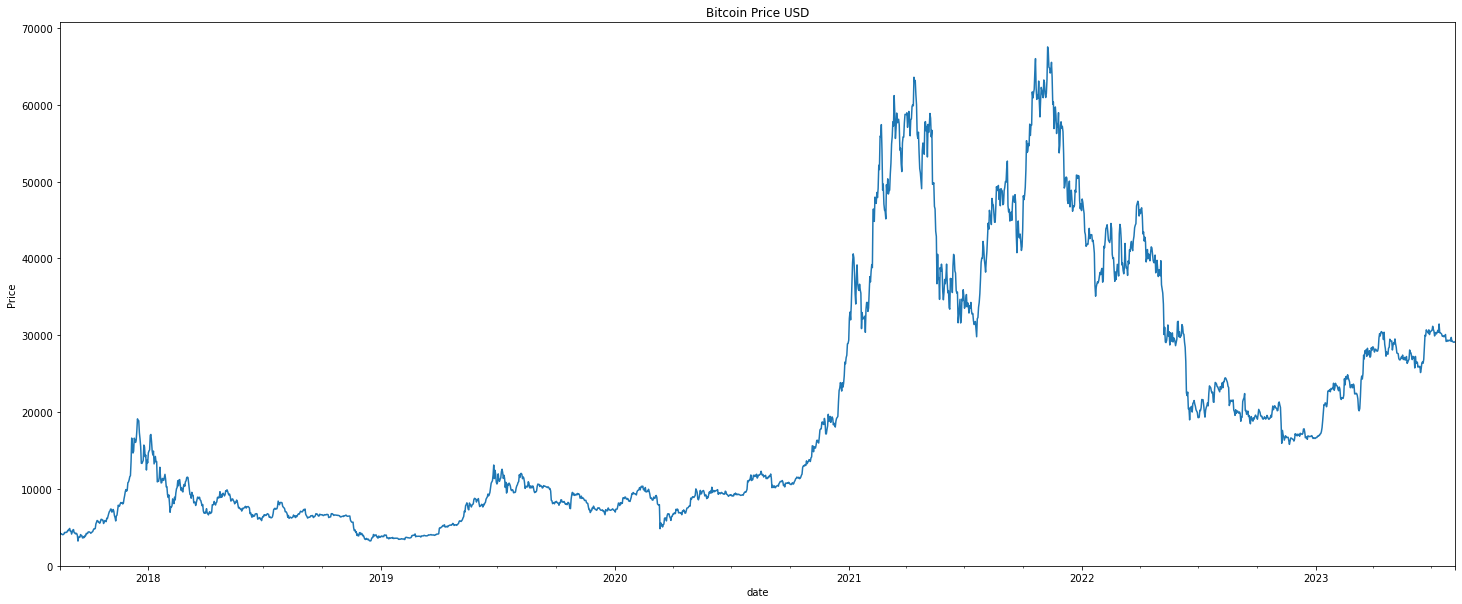

In [33]:
ax = df["close"].plot(title = 'Bitcoin Price USD')

plt.setp(ax,xlabel='date', ylabel='Price')
plt.rcParams["figure.figsize"] = (25,20)
plt.show()


In [25]:
x_date_sell = df["close"].idxmax()
y_price_sell = df.loc[x_date_sell].close

x_date_buy = df['close'].idxmin()
y_price_buy = df.loc[x_date_buy].close


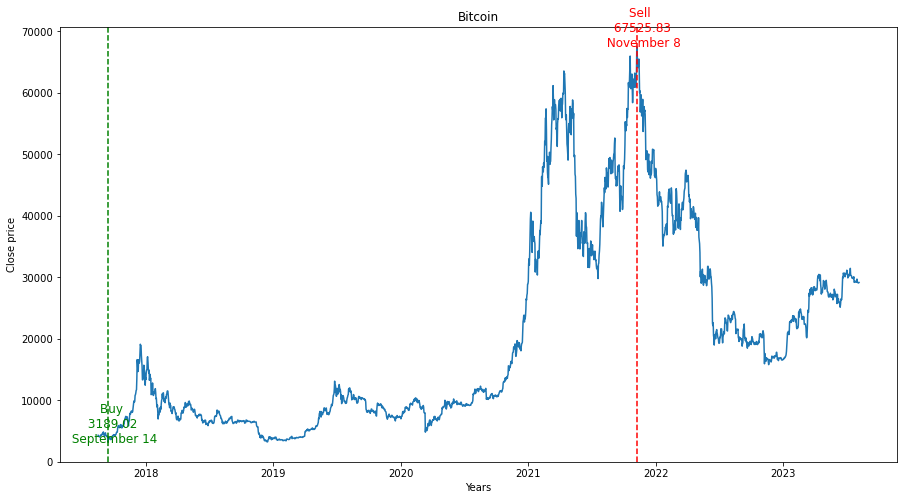

In [26]:
plt.figure(figsize=(15, 8))
sns.lineplot(x=df.index, y=df.close)

show_date_sell = f'{x_date_sell.strftime("%B")} {x_date_sell.day}'
show_date_buy = f'{x_date_buy.strftime("%B")} {x_date_buy.day}'

plt.text(x_date_sell + timedelta(days=15), y_price_sell - 0.012, f'Sell \n {round(y_price_sell,2)} \n {show_date_sell}', fontsize=12, ha='center', color = 'red')
plt.text(x_date_buy + timedelta(days=15), y_price_buy, f'Buy \n {round(y_price_buy,2)} \n {show_date_buy}', fontsize=12, ha='center', color = 'green')

plt.axvline(x=x_date_buy, color='green', linestyle='--')
plt.axvline(x=x_date_sell, color='red', linestyle='--')
plt.xlabel('Years')
plt.ylabel('Close price')
plt.title('Bitcoin')
plt.show()

# Get current Data + Automatic Trading
via BinanceSocketManager

In [50]:
bsm = BinanceSocketManager(client)
socket = bsm.kline_socket('BTCUSDT')
await socket.__aenter__()
msg = await socket.recv()
print(msg)
await socket.__aexit__(None, None, None)

{'e': 'kline', 'E': 1691387058151, 's': 'BTCUSDT', 'k': {'t': 1691387040000, 'T': 1691387099999, 's': 'BTCUSDT', 'i': '1m', 'f': 3186091390, 'L': 3186091506, 'o': '29137.47000000', 'c': '29134.01000000', 'h': '29137.47000000', 'l': '29134.00000000', 'v': '2.10692000', 'n': 117, 'x': False, 'q': '61387.21798350', 'V': '0.92403000', 'Q': '26922.57405800', 'B': '0'}}


In [51]:
def datatransform(msg):
    df2 = pd.DataFrame({'Time': msg['E'], 'Price':msg['k']['c']}, index=[0])
    df2.Price = df2.Price.astype(float)
    df2.Time = pd.to_datetime(df2.Time, unit='ms')
    return df2

In [52]:
datatransform(msg)

,Time,Price
0,2023-08-07 05:44:18.151,29134.01
